In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import rfft, rfftfreq
from scipy.signal.windows import blackman
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
def get_samples(num_samples, SAVE_PATH=''):
    
    cdata = np.empty((3,num_samples), dtype=np.complex128)
    # ADC_A is channel[3], ADC_C is channel[1], ADC_D is channel[0]
    for i, j in enumerate([3,1,0]):
        cdata[i,:] = np.array(base.radio.receiver.channel[j].transfer(num_samples))
    
    if SAVE_PATH:
        np.save('data/' + SAVE_PATH, cdata)
    
    return cdata

def save_data(data, SAVE_PATH=''):
    np.save('data/' + SAVE_PATH, data)
    return

In [3]:
from pynq.overlays.base import BaseOverlay
import xrfdc
import xrfclk
base = BaseOverlay('base.bit')
base.init_rf_clks()

In [4]:
DAC_A_Freq = 1499
DAC_B_Freq = 1495

ADC_A_Freq = -1475.
ADC_B_Freq = -1475.
ADC_C_Freq = -1475.
ADC_D_Freq = -1475.

In [5]:
# DAC_A - Checked, working
base.radio.transmitter.channel[1].dac_block.MixerSettings['Freq'] = DAC_A_Freq # MHz
base.radio.transmitter.channel[1].control.gain = 0.5
base.radio.transmitter.channel[1].control.enable = False

# DAC_B
base.radio.transmitter.channel[0].dac_block.MixerSettings['Freq'] = DAC_B_Freq # MHz
base.radio.transmitter.channel[0].control.gain = 0.5
base.radio.transmitter.channel[0].control.enable = False

# ADC_A
base.radio.receiver.channel[3].adc_block.MixerSettings['Freq'] = ADC_A_Freq # MHz
base.radio.receiver.channel[3].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)

# ADC_B
base.radio.receiver.channel[2].adc_block.MixerSettings['Freq'] = ADC_B_Freq # MHz
base.radio.receiver.channel[2].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)

# ADC_C
base.radio.receiver.channel[1].adc_block.MixerSettings['Freq'] = ADC_C_Freq # MHz
base.radio.receiver.channel[1].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)

# ADC_D
base.radio.receiver.channel[0].adc_block.MixerSettings['Freq'] = ADC_D_Freq # MHz
base.radio.receiver.channel[0].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)

In [6]:
NUM_REP = 100
NUM_SAMP = 32768
DECIMATION = 2
SAMP_FREQ = 4915.2e6/DECIMATION
CHANNELS = [0] # 0=ADC_A, 1=ADC_C, 2=ADC_D

In [16]:
%%time

blackmanWindow = np.tile(blackman(NUM_SAMP), (3,1))
freqdomain = rfftfreq(NUM_SAMP, 1/SAMP_FREQ)
freqdata = np.zeros((3,NUM_SAMP), dtype=np.float64)

progress = 0.0
for i in range(NUM_REP):
    if float(i)/NUM_REP > progress:
        print(f'Progress: {round(progress*100)}%')
        progress += 0.05
    
    data = get_samples(NUM_SAMP) # complex (I,Q) in time domain
    data = np.real(data) # picks out I-data in time domain
    data *= blackmanWindow # I-data with window
    dataf = np.abs(rfft(data[CHANNELS]))
    freqdata[CHANNELS,:] += dataf

freqdata /= NUM_REP # average over number of reps

Progress: 0%
Progress: 5%
Progress: 10%
Progress: 15%
Progress: 20%
Progress: 25%
Progress: 30%
Progress: 35%
Progress: 40%
Progress: 45%
Progress: 50%
Progress: 55%
Progress: 60%
Progress: 65%
Progress: 70%
Progress: 75%
Progress: 80%
Progress: 85%
Progress: 90%
Progress: 95%
CPU times: user 48.5 s, sys: 1.31 s, total: 49.8 s
Wall time: 1min 30s


In [66]:
# allData = np.zeros((4,NUM_SAMP), dtype=np.float64)
# allData[3,:] = freqdomain
# allData[0:3,:] = freqdata
# save_data(allData, SAVE_PATH='20250530-4_IP3_avg1000reps_DACs_LPfilter_UNNORMED_1475MHz')

# freqdata = np.load('data/20250530_IP3_avg1000reps_DACs_LPfilter_UNNORMED_1470MHz.npy')
# freqdomain = freqdata[-1,:]
# freqdomain, freqdata = freqdata[0,:], freqdata[1,:]

In [23]:
# Normalizations
freqdata /= NUM_SAMP
freqdata *= 2
freqdata /= np.sqrt(2)

# Retain un-channeled data
oldData = np.copy(freqdata)

In [24]:
# freqdata = np.load('data/20250522_IP3_avg1000reps_05gain_LPfilter.npy')
# freqdomain, freqdata = freqdata[0,:], freqdata[1,:]
# save_data(np.array([freqdomain, freqdata]), SAVE_PATH='20250528_IP3_avg1000reps_05gain_LPfilter_NORMED')

# dataf /= NUM_SAMP # normalize by number of samples
# dataf *= 2 # double b/c half the power is lost to the negative frequencies
# dataf /= np.sqrt(2) # convert volts to V_rms since we care about power

CHOOSE_CHANNEL = 0
freqdata = oldData[CHOOSE_CHANNEL,:]

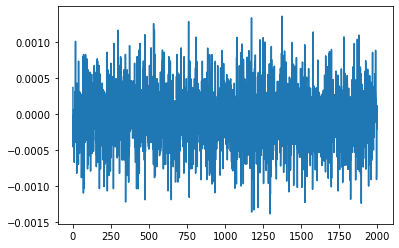

In [25]:
fig, ax = plt.subplots()
ax.plot(data[CHOOSE_CHANNEL,16000:18000])
plt.show()

In [26]:
# l_freq = 0e6 # Hz
# r_freq = SAMP_FREQ/DECIMATION # Hz
l_freq = (1497 + ADC_A_Freq - 8)*1e6
r_freq = (1497 + ADC_A_Freq + 8)*1e6
# l_freq = 0e6
# r_freq = 50e6

def get_ind(freq, SAMP_FREQ, DECIMATION, NUM_SAMP):
    return int(freq/(SAMP_FREQ/DECIMATION)*NUM_SAMP)

l_ind = get_ind(l_freq, SAMP_FREQ, DECIMATION, NUM_SAMP)
r_ind = get_ind(r_freq, SAMP_FREQ, DECIMATION, NUM_SAMP)

highertone = max(np.abs(DAC_A_Freq), np.abs(DAC_B_Freq))
lowertone = min(np.abs(DAC_A_Freq), np.abs(DAC_B_Freq))
mixtone1 = min(np.abs(DAC_A_Freq + ADC_C_Freq), np.abs(DAC_A_Freq - ADC_C_Freq)) # already in MHz
mixtone2 = min(np.abs(DAC_B_Freq + ADC_C_Freq), np.abs(DAC_B_Freq - ADC_C_Freq)) # already in MHz
cubic1 = 2*highertone - lowertone
cubic2 = 2*lowertone - highertone
cubicmix1 = cubic1 - np.abs(ADC_C_Freq)
cubicmix2 = cubic2 - np.abs(ADC_C_Freq)

In [27]:
# # Now need to convert from ADC V_rms into "real" ERASynth V_rms
# def myline(m, x):
#     return m*x

# popt = np.load('calib/gain.npy')
# vrms = myline(freqdata, *popt)

print(np.amax(freqdata))
powerdata = freqdata*freqdata/50 * 1e3 # Convert V_rms to mW, this is power of the output (i.e. power of signal measured by ADC)
print(f'Max power: {round(np.amax(powerdata), 5)} mW')


5.330554411010091e-05
Max power: 0.0 mW


[29.25  17.1   19.575 16.125 29.625 20.25  14.85  23.7   29.175 15.525
 16.95  18.9   29.25  27.525 19.5   24.6   20.7   20.325 27.15  18.075
 16.05  16.575 28.05  15.975 17.85  21.75  21.975 27.225 25.8   22.2
 27.675 24.9   16.875 20.775 23.625 24.825 23.325 29.175 16.575 22.05
 23.775 28.2   16.5   15.9   26.25  25.725 21.3   26.175 14.025 28.125]


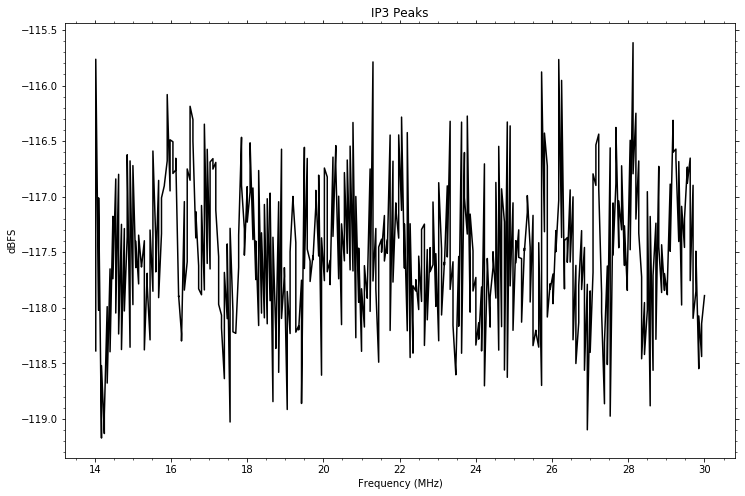

In [28]:
plotdomain = freqdomain[l_ind:r_ind]*1e-6 # Convert to MHz
maxpower = 10 # mW, this is from (1/sqrt(2))^2/50 *1e3
plotdata = np.copy(powerdata[l_ind:r_ind])/maxpower
plotdata = 10*np.log10(plotdata) # in dBFS, use 10 prefactor b/c powers


print(plotdomain[np.argsort(plotdata)][-50:])
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(plotdomain, plotdata, color='black')
# ax.axvline(mixtone1, color='red')
# ax.axvline(mixtone2, color='red')
# ax.axvline(cubicmix1, color='red')
# ax.axvline(cubicmix2, color='red')
ax.set_title('IP3 Peaks')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('dBFS')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.show()

In [29]:
sublength = len(plotdata)

def get_ind_again(freq, plotdomain):
    freq -= plotdomain[0]
    freq = max(0, freq)
    domainlength = len(plotdomain)
    domainscale = plotdomain[-1] - plotdomain[0]
    return int(freq/domainscale * domainlength)

l_ind = get_ind_again((cubicmix2 - 0.5), plotdomain)
r_ind = get_ind_again((cubicmix2 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
lcubic_power = np.max(plotdata[l_ind:r_ind][peakinds])

l_ind = get_ind_again((cubicmix1 - 0.5), plotdomain)
r_ind = get_ind_again((cubicmix1 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
rcubic_power = np.max(plotdata[l_ind:r_ind][peakinds])

avgcubic_power = 0.5*(lcubic_power + rcubic_power)
print(f'Average IM3 Power: {round(avgcubic_power,1)} dBFS')

l_ind = get_ind_again((mixtone2 - 0.5), plotdomain)
r_ind = get_ind_again((mixtone2 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
ltone_power = np.max(plotdata[l_ind:r_ind][peakinds])

l_ind = get_ind_again((mixtone1 - 0.5), plotdomain)
r_ind = get_ind_again((mixtone1 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
rtone_power = np.max(plotdata[l_ind:r_ind][peakinds])

avgtone_power = 0.5*(ltone_power + rtone_power)
print(f'Average Fundamental Power: {round(avgtone_power,1)} dBFS')

deltaP = avgtone_power - avgcubic_power
print(f'Delta P: {round(deltaP, 1)} dB')
OIP3 = avgtone_power + 0.5*deltaP
print(f'OIP3: {round(OIP3,1)} dBFS')

popt = np.load('calib/gain.npy')
gain = 1/popt[0] # since popt[0] is slope of ERASynth V_rms vs. ADC V_rms, gain is from input->output, so 1/slope
gain = 20*np.log10(gain) # now in dB, use 20 b/c gain is associated with voltages
IIP3 = OIP3 - gain
print(f'IIP3: {round(IIP3,1)} dBFS')

Average IM3 Power: -115.8 dBFS
Average Fundamental Power: -116.4 dBFS
Delta P: -0.6 dB
OIP3: -116.7 dBFS
IIP3: -114.6 dBFS


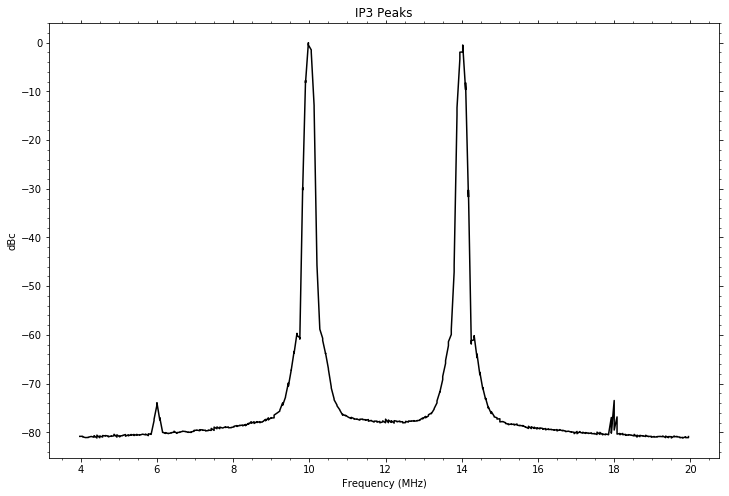

In [16]:
plotdomain = freqdomain[l_ind:r_ind]*1e-6 # Convert to MHz
maxRecPower = np.amax(powerdata)
plotdata = np.copy(powerdata[l_ind:r_ind])/maxRecPower
plotdata = 10*np.log10(plotdata) # now in dBc, use 10 prefactor b/c powers

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(plotdomain, plotdata, color='black')
# ax.axvline(mixtone1, color='red')
# ax.axvline(mixtone2, color='red')
# ax.axvline(cubicmix1, color='red')
# ax.axvline(cubicmix2, color='red')
ax.set_title('IP3 Peaks')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('dBc')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.show()

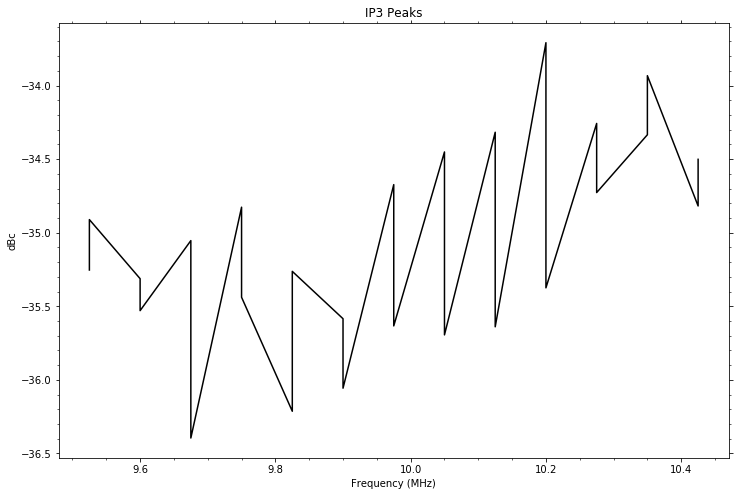

In [30]:
plotdomain = freqdomain[l_ind:r_ind]*1e-6 # Convert to MHz
maxRecPower = np.amax(powerdata)
plotdata = np.copy(powerdata[l_ind:r_ind])/maxRecPower
plotdata = 10*np.log10(plotdata) # now in dBc, use 10 prefactor b/c powers

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(plotdomain, plotdata, color='black')
# ax.axvline(mixtone1, color='red')
# ax.axvline(mixtone2, color='red')
# ax.axvline(cubicmix1, color='red')
# ax.axvline(cubicmix2, color='red')
ax.set_title('IP3 Peaks')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('dBc')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.show()

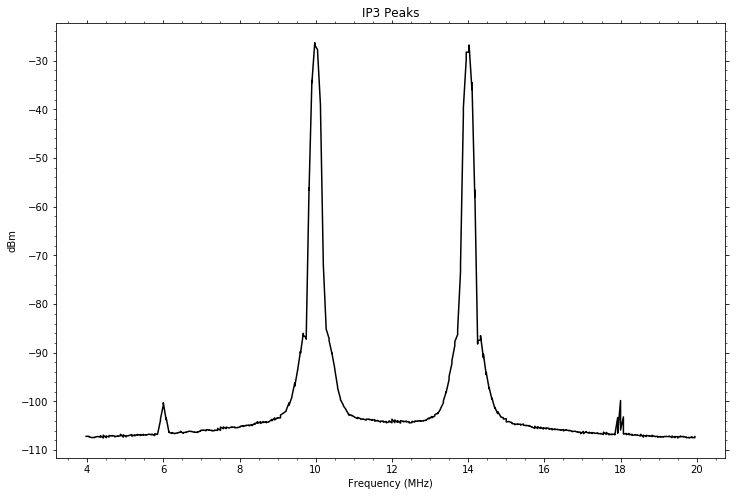

In [17]:
plotdomain = freqdomain[l_ind:r_ind]*1e-6 # Convert to MHz
plotdata = np.copy(powerdata[l_ind:r_ind])
plotdata = 10*np.log10(plotdata)        # now in dBm

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(plotdomain, plotdata, color='black')
# ax.axvline(mixtone1, color='red')
# ax.axvline(mixtone2, color='red')
# ax.axvline(cubicmix1, color='red')
# ax.axvline(cubicmix2, color='red')
ax.set_title('IP3 Peaks')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('dBm')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.show()

In [19]:
sublength = len(plotdata)

def get_ind_again(freq, plotdomain):
    freq -= plotdomain[0]
    freq = max(0, freq)
    domainlength = len(plotdomain)
    domainscale = plotdomain[-1] - plotdomain[0]
    return int(freq/domainscale * domainlength)

l_ind = get_ind_again((cubicmix2 - 0.5), plotdomain)
r_ind = get_ind_again((cubicmix2 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
lcubic_power = np.max(plotdata[l_ind:r_ind][peakinds])

l_ind = get_ind_again((cubicmix1 - 0.5), plotdomain)
r_ind = get_ind_again((cubicmix1 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
rcubic_power = np.max(plotdata[l_ind:r_ind][peakinds])

avgcubic_power = 0.5*(lcubic_power + rcubic_power)
print(f'Average IM3 Power: {round(avgcubic_power,1)} dBm')

l_ind = get_ind_again((mixtone2 - 0.5), plotdomain)
r_ind = get_ind_again((mixtone2 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
ltone_power = np.max(plotdata[l_ind:r_ind][peakinds])

l_ind = get_ind_again((mixtone1 - 0.5), plotdomain)
r_ind = get_ind_again((mixtone1 + 0.5), plotdomain)
peakinds = find_peaks(plotdata[l_ind:r_ind], distance=5)[0]
rtone_power = np.max(plotdata[l_ind:r_ind][peakinds])

avgtone_power = 0.5*(ltone_power + rtone_power)
print(f'Average Fundamental Power: {round(avgtone_power,1)} dBm')

deltaP = avgtone_power - avgcubic_power
OIP3 = avgtone_power + 0.5*deltaP
print(f'OIP3: {round(OIP3,1)} dBm')

popt = np.load('calib/gain.npy')
gain = 1/popt[0] # since popt[0] is slope of ERASynth V_rms vs. ADC V_rms, gain is from input->output, so 1/slope
gain = 20*np.log10(gain) # now in dB, use 20 b/c gain is associated with voltages
IIP3 = OIP3 - gain
print(f'IIP3: {round(IIP3,1)} dBm')

Average IM3 Power: -100.0 dBm
Average Fundamental Power: -26.6 dBm
OIP3: 10.2 dBm
IIP3: 12.3 dBm


In [92]:
# Now calculating ratio of a_1 to a_3
AIIP3 = np.sqrt(50*1e-3*10**(0.1*IIP3)) # Amplitude, in V_rms, of IIP3
ratio = 0.75*AIIP3*AIIP3 # this is in Volts^2, ratio of a1 to a3
maxRecPower = np.amax(powerdata)
maxRecAmpRMS = np.sqrt(maxRecPower*1e-3*50)
relIM = 20*np.log10(0.75/ratio*maxRecAmpRMS*maxRecAmpRMS) # in dBc
print(relIM)
print(1/(10**(relIM/20)))

-76.07339945471253
6363.117937117547


In [85]:
# save_data(np.array([freqdomain, freqdata]), SAVE_PATH='20250522_IP3_avg1000reps_05gain_LPfilter')

In [7]:
num_chans = iqdata.shape[0]
num_samples = iqdata.shape[1]
print(f'{num_samples} in each of {num_chans} channel(s)')

chan_a = iqdata[0,:]
chan_c = iqdata[1,:]
chan_d = iqdata[2,:]

NameError: name 'iqdata' is not defined

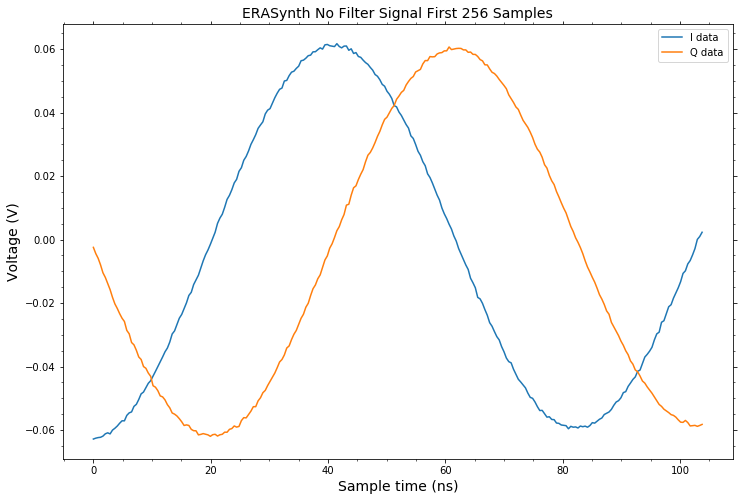

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
f_s = 2457.6e6
sample_times = np.arange(0, num_samples/f_s, 1/f_s)*1e9
idata = np.real(chan_c)
qdata = np.imag(chan_c)
ax.plot(sample_times[0:256], idata[0:256], label='I data')
ax.plot(sample_times[0:256], qdata[0:256], label='Q data')
ax.legend()
ax.set_title('ERASynth No Filter Signal First 256 Samples', fontdict=dict(size=14))
ax.set_ylabel('Voltage (V)', fontdict=dict(size=14))
ax.set_xlabel('Sample time (ns)', fontdict=dict(size=14))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.show()

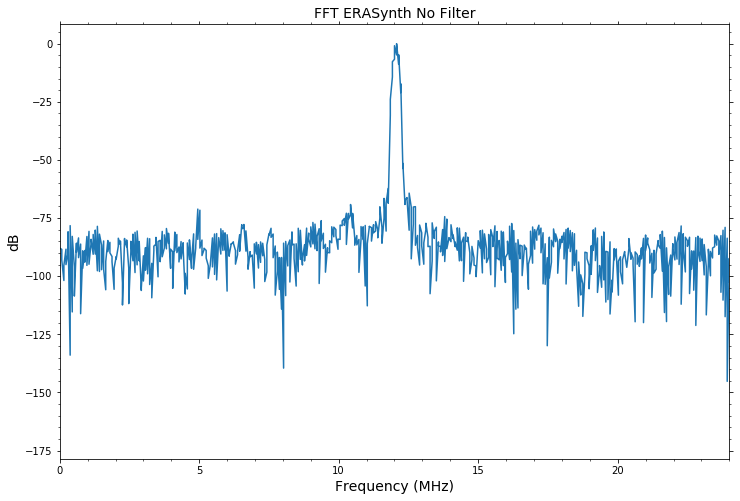

Peak frequencies:
	12.075 MHz


In [9]:
blackman_window = blackman(num_samples)
idata_f = np.abs(rfft(blackman_window*idata))
idata_f = idata_f/np.amax(idata_f)
idata_f = 20*np.log10(idata_f)
freqs = rfftfreq(num_samples, 1/f_s)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(freqs*1e-6, idata_f)
ax.set_xlim(0,24)
ax.set_title('FFT ERASynth No Filter', fontdict=dict(size=14))
ax.set_ylabel('dB', fontdict=dict(size=14))
ax.set_xlabel('Frequency (MHz)', fontdict=dict(size=14))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
# ax.text(30,0,'Sig$_1$, LO$_1$', fontdict=dict(size=12))
# ax.text(90,-18,'Sig$_3$, LO$_3$', fontdict=dict(size=12))
# ax.text(160,-28,'Sig$_5$, LO$_5$', fontdict=dict(size=12))
# ax.text(950,-48,'Sig$_6$, LO$_5$', fontdict=dict(size=12))
# ax.text(1020,-34,'Sig$_6$, LO$_5$', fontdict=dict(size=12))
# ax.text(1170,-35,'Sig$_6$, LO$_5$', fontdict=dict(size=12))
plt.minorticks_on()
plt.show()

peak_indices = find_peaks(idata_f, height=-60, distance=10)[0]
print('Peak frequencies:')
for peak_index in peak_indices:
    print(f'\t{round(freqs[peak_index]*1e-6, 3)} MHz')

NameError: name 'base' is not defined